## Import the libraries

In [1]:
import tensorflow as tf
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

import h5py
import keras
import numpy as np
import pandas as pd
import plotly.graph_objs as go
from keras.layers import (
    BatchNormalization,
    Conv3D,
    Dense,
    Dropout,
    Flatten,
    Input,
    MaxPool3D,
)
from keras.losses import categorical_crossentropy, mean_squared_error
from keras.models import Model
from keras.optimizers import Adadelta, Adam
from matplotlib.pyplot import cm
from plotly.offline import init_notebook_mode, iplot
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras import backend as K

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

2023-12-21 13:03:01.340449: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-21 13:03:01.362811: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-21 13:03:01.362832: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-21 13:03:01.363791: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-21 13:03:01.368423: I tensorflow/core/platform/cpu_feature_guar

2.15.0
Num GPUs Available:  1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15389523347819198983
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4528209920
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17358231057325228847
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


2023-12-21 13:03:02.680989: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-21 13:03:02.710281: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-21 13:03:02.710465: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
def limitgpu(maxmem):
	gpus = tf.config.list_physical_devices('GPU')
	if gpus:
		# Restrict TensorFlow to only allocate a fraction of GPU memory
		try:
			for gpu in gpus:
				tf.config.experimental.set_virtual_device_configuration(gpu,
						[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=maxmem)])
		except RuntimeError as e:
			# Virtual devices must be set before GPUs have been initialized
			print(e)


# 1.5GB
limitgpu(1024+512) 

## Read the neighbor information from the CSV files

In [2]:
Re = 100
phi = 10
shape = "tetra"

if phi == 5:
    phi_sys = "0p05"
    N_par = 1146
elif phi == 10:
    phi_sys = "0p1"
    N_par = 2292
else:
    phi_sys = "0p2"
    N_par = 2197

box_size = 51
D = 0.001
X_data = np.ndarray((N_par, box_size, box_size, box_size, 1))

for m in range(N_par):
    if m%100 == 0:
        print("Particle " +str(m)+ " has done")
    my_path = "Particle_Image/"+shape+"_"+phi_sys+"/parID_"+str(m)+".csv"
    my_data = pd.read_csv(my_path).to_numpy()[:,1:]
    my_data_nonzero = np.min(my_data[my_data[:,-1]>0][:,-1])
    for i in range(box_size):
        for j in range(box_size):
            for k in range(box_size):
                if my_data[i*box_size**2+j*box_size+k,3] == 0:
                    # X_data[m,j,k,i,0] = 0
                    X_data[m,i,j,k,0] = 0
                else:
                    # X_data[m,j,k,i,0] = my_data_nonzero/my_data[i*box_size**2+j*box_size+k,3]
                    X_data[m,i,j,k,0] = my_data_nonzero/my_data[i*box_size**2+j*box_size+k,3]
print("Finish!")

Particle 0 has done
Particle 100 has done
Particle 200 has done
Particle 300 has done
Particle 400 has done
Particle 500 has done
Particle 600 has done
Particle 700 has done
Particle 800 has done
Particle 900 has done
Particle 1000 has done
Particle 1100 has done
Particle 1200 has done
Particle 1300 has done
Particle 1400 has done
Particle 1500 has done
Particle 1600 has done
Particle 1700 has done
Particle 1800 has done
Particle 1900 has done
Particle 2000 has done
Particle 2100 has done
Particle 2200 has done
Finish!


In [38]:
X_data[0,:,0,0,:]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

## Store the particle location matrix

In [4]:
phi = 10
shape = "tetra"

if phi == 5:
    phi_sys = "0p05"
elif phi == 10:
    phi_sys = "0p1"
else:
    phi_sys = "0p2"

my_path = "Dataset/"+shape+"_"+phi_sys
os.chdir(my_path)
np.save('particles.npy',X_data)
os.chdir("../../")

## Restore the particle location matrix

In [6]:
Re = 100
phi = 10
shape = "tetra"

if phi == 5:
    phi_sys = "0p05"
elif phi == 10:
    phi_sys = "0p1"
else:
    phi_sys = "0p2"

my_path = "Dataset/"+shape+"_"+phi_sys
os.chdir(my_path)
X_data = np.load('particles.npy')
os.chdir("../../")

X_data[0,0,:,0,:]

array([[0.        ],
       [0.        ],
       [0.01559868],
       [0.01584057],
       [0.01584057],
       [0.01608039],
       [0.01631713],
       [0.01654972],
       [0.01677699],
       [0.01699773],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.   

## Read the forces and torques

In [22]:
Re = 100
phi = 10
shape = "tetra"

D = 0.001
rho = 1000
u = 0.02

if phi == 5:
    phi_sys = "0p05"
    N_par = 1146
    Lx = (0.025-0.002)/D
    Ly = (0.024875-0.002)/D
    Lz = (0.0248125-0.002)/D
elif phi == 10:
    phi_sys = "0p1"
    N_par = 2292
    Lx = (0.025-0.002)/D
    Ly = (0.024875-0.002)/D
    Lz = (0.0248125-0.002)/D
else:
    phi_sys = "0p2"
    N_par = 2197
    Lx = (0.01992-0.002)/D
    Ly = (0.01992-0.002)/D
    Lz = (0.01992-0.002)/D
    
if Re == 1:
    mu = 0.02
elif Re == 10:
    mu = 0.002 
else:
    mu = 0.0002     

F_scale = 3.*np.pi*mu*D*u

path_name = "Platonic_Data/"+shape+"_phi_"+phi_sys+"_Re_"+str(Re)+"/particle_forces.csv"
datafile = pd.read_table(path_name, delimiter=',', skiprows=0)[-N_par:]
x_force, y_force, z_force = (datafile.iloc[:,11].to_numpy()+datafile.iloc[:,14].to_numpy()).reshape(-1,1)/F_scale,\
                            (datafile.iloc[:,12].to_numpy()+datafile.iloc[:,15].to_numpy()).reshape(-1,1)/F_scale,\
                            (datafile.iloc[:,13].to_numpy()+datafile.iloc[:,16].to_numpy()).reshape(-1,1)/F_scale
Y_data = np.copy(x_force)

In [23]:
scaler = preprocessing.StandardScaler().fit(Y_data)
Y_data = scaler.transform(Y_data)
Y_data

array([[ 0.47393873],
       [ 0.35368763],
       [ 0.21114188],
       ...,
       [ 1.34887933],
       [-1.59266746],
       [-0.53856832]])

## Train and test sets split

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=42, shuffle=False)

## Construct the model

In [24]:
N_filter = 2

## input layer
input_layer = Input((51, 51, 51, 1))

# filter is the number of kernels, 
## convolutional layers
conv_layer1 = Conv3D(filters=N_filter, kernel_size=(3, 3, 3), activation='relu')(input_layer)
## add max pooling to obtain the most imformatic features
conv_layer1 = BatchNormalization()(conv_layer1)
# conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 3), activation='relu')(conv_layer1)
# conv_layer2 = BatchNormalization()(conv_layer2)
pooling_layer1 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer1)
# pooling_layer1 = Dropout(0.25)(pooling_layer1)
# pooling_layer1 = BatchNormalization()(pooling_layer1)

# strides give you the ghost layer
## convolutional layers
conv_layer2 = Conv3D(filters=2*N_filter, kernel_size=(3, 3, 3), activation='relu',strides = 1,padding='same')(pooling_layer1)
conv_layer2 = BatchNormalization()(conv_layer2)
# conv_layer4 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer3)
# conv_layer4 = BatchNormalization()(conv_layer4)
pooling_layer2 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer2)
# pooling_layer2 = Dropout(0.25)(pooling_layer2)
# pooling_layer2 = BatchNormalization()(pooling_layer2)

## convolutional layers
conv_layer3 = Conv3D(filters=4*N_filter, kernel_size=(3, 3, 3), activation='relu')(pooling_layer2)
conv_layer3 = BatchNormalization()(conv_layer3)
conv_layer4 = Conv3D(filters=4*N_filter, kernel_size=(3, 3, 3), activation='relu')(conv_layer3)
conv_layer4 = BatchNormalization()(conv_layer4)
pooling_layer3 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer4)
# pooling_layer3 = Dropout(0.25)(pooling_layer3)
# pooling_layer3 = BatchNormalization()(pooling_layer3)

conv_layer5 = Conv3D(filters=8*N_filter, kernel_size=(3, 3, 3), activation='relu')(pooling_layer3)
conv_layer5 = BatchNormalization()(conv_layer5)
pooling_layer4 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer5)

# conv_layer5 = Conv3D(filters=128, kernel_size=(3, 3, 3), activation='relu')(pooling_layer4)
# conv_layer5 = BatchNormalization()(conv_layer5)
# pooling_layer5 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer5)

## perform batch normalization on the convolution outputs before feeding it to MLP architecture
flatten_layer = Flatten()(pooling_layer4)

## create an MLP architecture with dense layers 
## add dropouts to avoid overfitting / perform regularization
# flatten_layer = BatchNormalization()(flatten_layer)
# unit is the number of neurons
dense_layer1 = Dense(units=8*N_filter, activation='tanh')(flatten_layer)
# dense_layer1 = Dropout(0.5)(dense_layer1)
# dense_layer1 = BatchNormalization()(dense_layer1)

# dense_layer2 = Dense(units=16, activation='tanh')(dense_layer1)
# # dense_layer2 = Dropout(0.5)(dense_layer2)
# # dense_layer2 = BatchNormalization()(dense_layer2)

output_layer = Dense(units=1, activation='linear')(dense_layer1)

## define the model with input layer and output layer
model = Model(inputs=input_layer, outputs=output_layer)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 51, 51, 51, 1)]   0         
                                                                 
 conv3d_15 (Conv3D)          (None, 49, 49, 49, 2)     56        
                                                                 
 batch_normalization_15 (Ba  (None, 49, 49, 49, 2)     8         
 tchNormalization)                                               
                                                                 
 max_pooling3d_12 (MaxPooli  (None, 24, 24, 24, 2)     0         
 ng3D)                                                           
                                                                 
 conv3d_16 (Conv3D)          (None, 24, 24, 24, 4)     220       
                                                                 
 batch_normalization_16 (Ba  (None, 24, 24, 24, 4)     16  

## Implement the model

In [25]:
def R2(y_true, y_pred):
        '''
        This function computes the R^2 for the callback function.
        '''
        SS_res = K.sum(K.square(y_true - y_pred)) 
        SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
        return 1 - SS_res / SS_tot

model.compile(loss='mae', optimizer=Adam(learning_rate=1e-3), metrics=R2)
history = model.fit(x=X_data, y=Y_data, batch_size=32, epochs=100, validation_split=0.2)

Epoch 1/100
58/58 [==============================] - 4s 53ms/step - loss: 0.7972 - R2: -0.0671 - val_loss: 0.7912 - val_R2: -0.0592
Epoch 2/100
58/58 [==============================] - 2s 26ms/step - loss: 0.7520 - R2: 0.0620 - val_loss: 0.7873 - val_R2: -0.0519
Epoch 3/100
58/58 [==============================] - 2s 26ms/step - loss: 0.7116 - R2: 0.1469 - val_loss: 0.7851 - val_R2: -0.0439
Epoch 4/100
58/58 [==============================] - 2s 26ms/step - loss: 0.6680 - R2: 0.2379 - val_loss: 0.7782 - val_R2: -0.0333
Epoch 5/100
58/58 [==============================] - 2s 27ms/step - loss: 0.6375 - R2: 0.3054 - val_loss: 0.7826 - val_R2: -0.0567
Epoch 6/100
58/58 [==============================] - 2s 26ms/step - loss: 0.6119 - R2: 0.3595 - val_loss: 0.7625 - val_R2: -0.0082
Epoch 7/100
58/58 [==============================] - 2s 27ms/step - loss: 0.5885 - R2: 0.3962 - val_loss: 0.7293 - val_R2: 0.0750
Epoch 8/100
58/58 [==============================] - 2s 27ms/step - loss: 0.5696 - 

Text(0, 0.5, 'MSE Loss')

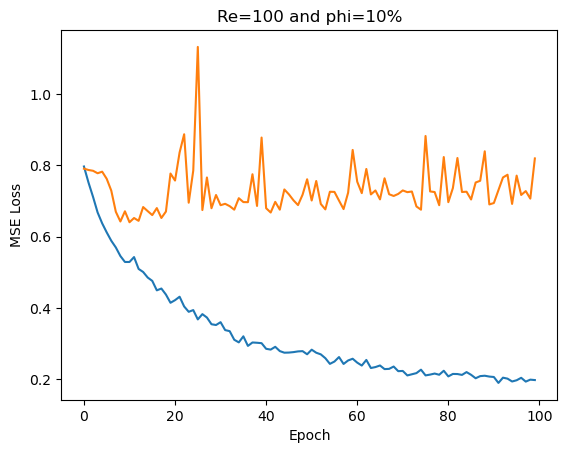

In [26]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'Re={Re} and phi={phi}%')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
# plt.savefig(f'Loss_Re_{Re}_phi_'+phi_sys+'.png',dpi=200,bbox_inches="tight")

Text(0, 0.5, 'R2')

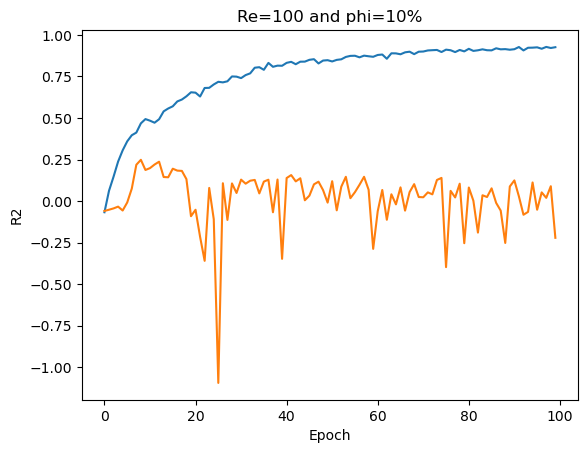

In [27]:
plt.plot(history.history['R2'])
plt.plot(history.history['val_R2'])
plt.title(f'Re={Re} and phi={phi}%')
plt.xlabel('Epoch')
plt.ylabel('R2')
# plt.ylim([0,1])
# plt.savefig(f'R2_Re_{Re}_phi_'+phi_sys+'.png',dpi=200,bbox_inches="tight")